## Import necessary packages

In [1]:
# Add ../../ to path
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

In [2]:
import sys

from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

from cyclum import writer
from scPPR.periodic_inference import PeriodicInference
from scPPR.stage_classifier import StageClassifier
from scPPR.plot import plot_inference

## Read data

In [3]:
raw_Y = pd.read_pickle('../data/McDavid/h9_df.pkl').T

cpt = pd.read_pickle('../data/McDavid/h9_cpt.pkl').values
print("Original dimesion %d cells x %d genes." % raw_Y.shape)
print(f"G0/G1 {sum(cpt == 'g0/g1')}, S {sum(cpt == 's')}, G2/M {sum(cpt == 'g2/m')}")
gene_df = raw_Y
gene_df.index = cpt[:,0]
gene_df = gene_df.T

Original dimesion 227 cells x 253 genes.
G0/G1 [66], S [68], G2/M [93]


## SVD

In [4]:
def eigenexpression_fraction(sigma):
    sigma_power = np.power(sigma, 2)
    return sigma_power / np.sum(sigma_power)

def shannon_entropy(exp_fraction):
    return -1 / np.log(len(exp_fraction)) * np.sum(exp_fraction * np.log(exp_fraction))

U, sigma, VT = np.linalg.svd(gene_df, full_matrices=False)
exp_fraction = eigenexpression_fraction(sigma)
entropy = shannon_entropy(exp_fraction)
print(exp_fraction[:30], entropy)

[9.51774413e-01 1.59246119e-02 2.91197162e-03 2.52200359e-03
 1.19414599e-03 9.23332535e-04 7.88410632e-04 6.50877002e-04
 6.14406974e-04 5.76452536e-04 5.25514027e-04 4.88786375e-04
 4.77109344e-04 4.68116322e-04 4.34476870e-04 4.33086051e-04
 4.18905102e-04 4.18264943e-04 4.12164351e-04 4.02613638e-04
 3.86465952e-04 3.80507296e-04 3.75176665e-04 3.60482510e-04
 3.53412991e-04 3.41869201e-04 3.24578693e-04 3.23260170e-04
 3.18060878e-04 3.11759983e-04] 0.06778933883332824


In [5]:
# choose eigngene1,..., eigngene4
V = VT.T
V_scaled = preprocessing.scale(V)

data = V_scaled[:, 1:5]
N = 500
per_inf = PeriodicInference(N, N_iterations_MCMC = int(1e4), N_passes_optimisation=0)
ml_phases, ml_likelihood, samples_phase, samples_likelihood = per_inf.estimate_uncertainty(data)
# import pickle
# with open('/Users/spark/git3/pySuStaIn/h9_chen_eign4.pickle', 'rb') as pickle_file:
#     save_variables = pickle.load(pickle_file)
#     ml_phases = save_variables["ml_phases"]
#     samples_phase = save_variables["samples_phase"]
#     ml_likelihood = save_variables["ml_likelihood"]
#     samples_likelihood = save_variables["samples_likeilhood"]

# print(ml_phases[:,0])

individual_phases = per_inf.predict_phases(data, ml_phases[:,0])

phase_init:  [0.         0.92991143 6.10725612 1.60849544]
Optimise mcmc settings
phase_sigma_opt:  1.0
Run mcmc
Iteration 0 of 10000 , 0 % complete
Iteration 1000 of 10000 , 10 % complete
Iteration 2000 of 10000 , 20 % complete
Iteration 3000 of 10000 , 30 % complete
Iteration 4000 of 10000 , 40 % complete
Iteration 5000 of 10000 , 50 % complete
Iteration 6000 of 10000 , 60 % complete
Iteration 7000 of 10000 , 70 % complete
Iteration 8000 of 10000 , 80 % complete
Iteration 9000 of 10000 , 90 % complete
Accept Ratio: 0.4721


## Plot

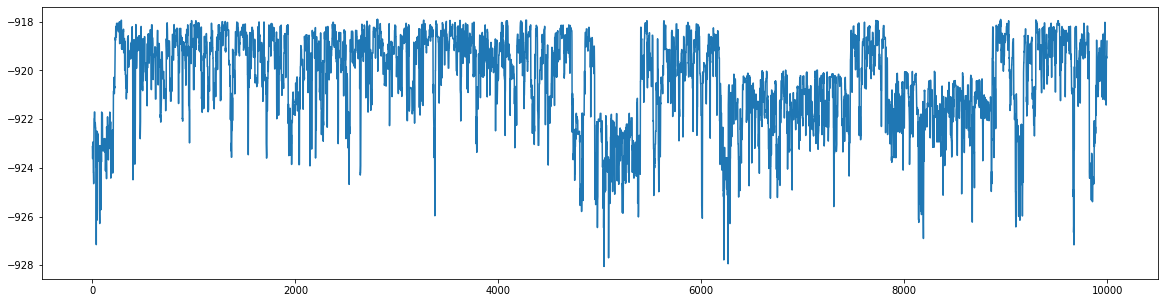

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(samples_likelihood)), samples_likelihood)
plt.show()

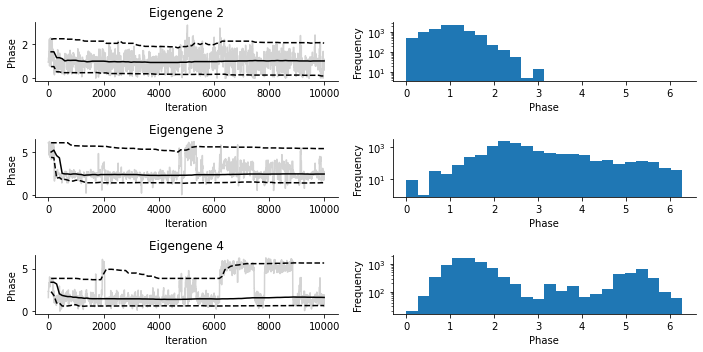

In [7]:
plot_inference(samples_phase)

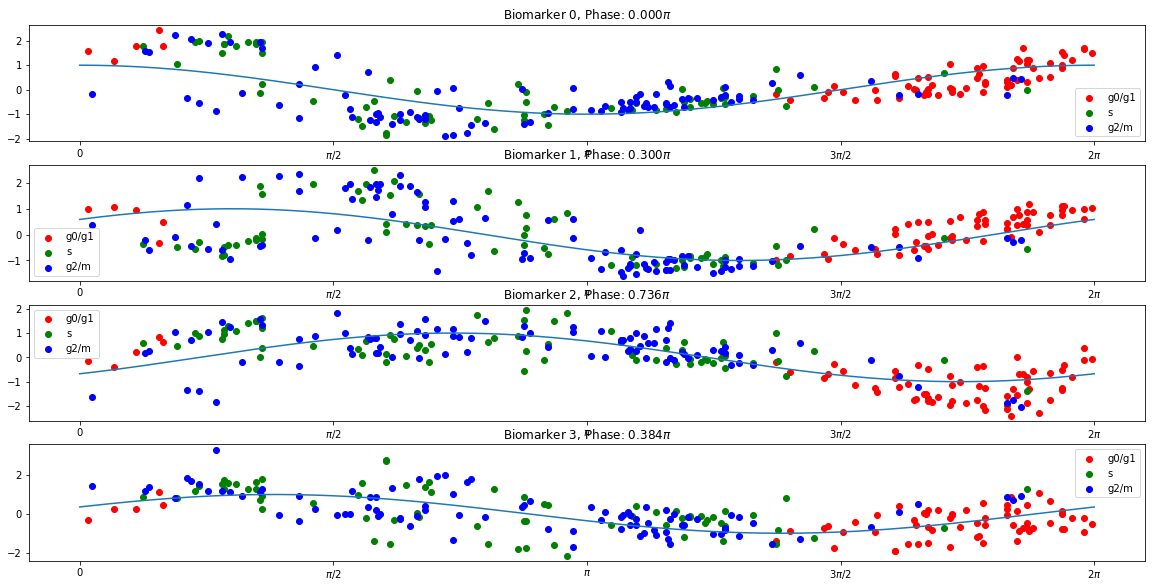

In [8]:
n_biomarkers = 6
plt.figure(figsize=(20, 15))
bins = np.linspace(0, 2 * np.pi, 1000)
tick_bins = np.linspace(0, 2 * np.pi, 5)
ticks = ['0', r'$\pi$/2', r'$\pi$', r'3$\pi$/2', r'2$\pi$']
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}

for i, phase in enumerate(ml_phases[:,0]):
    gt = np.cos(bins - phase)
    plt.subplot(n_biomarkers, 1, i+1)
    plt.plot(bins, gt)
    for l, c in color_map['stage'].items():
        index = gene_df.columns == l
        plt.scatter(individual_phases[index], data[index][:,i], label=l, color=c)
    plt.title('Biomarker {}, Phase: {:.3f}$\pi$'.format(i, phase/np.pi))
    plt.xticks(tick_bins, ticks, rotation=0)
    plt.tick_params(labelsize=10)
    plt.legend(loc='best')
plt.show()

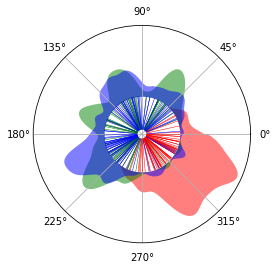

In [9]:
import cyclum.illustration
cyclum.illustration.plot_round_distr_color(individual_phases, gene_df.columns, color_map['stage'])
pass